In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from scipy import spatial
sys.path.append("../gotmtool")
from gotmtool import *

## Load data

In [2]:
dataroot = '../ERA5_plus_STD'
sd_filename = 'era5flux.nc'
argo_filename = 'argo_along_sd.nc'

In [3]:
sd_ds = xr.open_dataset(os.path.join(dataroot, sd_filename))
argo_ds = xr.open_dataset(os.path.join(dataroot, argo_filename))

In [4]:
sd_ds

<xarray.Dataset>
Dimensions:  (time: 1285)
Coordinates:
  * time     (time) float64 31.02 31.06 31.1 31.15 ... 84.4 84.44 84.48 84.52
Data variables:
    lon      (time) float64 ...
    lat      (time) float64 ...
    qlat     (time) float64 ...
    qsens    (time) float64 ...
    lw       (time) float64 ...
    sw       (time) float64 ...
    tau      (time) float64 ...
    U        (time) float64 ...
    Udir     (time) float64 ...

In [5]:
argo_ds

<xarray.Dataset>
Dimensions:  (lev: 1000, time: 158)
Coordinates:
  * lev      (lev) int32 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * time     (time) float64 31.9 31.7 31.59 31.1 ... 86.2 88.55 89.33 89.09
Data variables:
    z        (time, lev) float64 ...
    temp     (time, lev) float64 ...
    salt     (time, lev) float64 ...
    lon      (time) float64 ...
    lat      (time) float64 ...

## Save shortwave radiation

In [6]:
year = 2019
doy = sd_ds.time.data
dttime_sd = [(pd.to_datetime(year*1000 + np.floor(d), format='%Y%j') 
             + pd.to_timedelta((d-np.floor(d))*86400, unit='S')) for d in doy]
dat_dump_ts(dttime_sd,
            [sd_ds.sw.data],
            os.path.join(dataroot, 'swr_era5.dat'),
            skip_value=np.nan)

## Argo T/S profiles, heat and momentum fluxes at selected locations

In [7]:
ncase = 10
istart = 30

In [8]:
nsd = sd_ds.time.size
tlast = 70
nlast = np.argmin(np.abs(sd_ds.time.data-tlast))
step = int(np.floor(nlast/(ncase-1)))
idx_sd = np.arange(istart,nlast,step)

In [9]:
print('Indices = {}'.format(idx_sd))
print('Time = {}'.format(sd_ds.time[idx_sd].data))

Indices = [ 30 133 236 339 442 545 648 751 854]
Time = [32.27118056 36.56284722 40.85451389 45.14618056 49.43784722 53.72951389
 58.02118056 62.31284722 66.60451389]


In [10]:
# nearest argo points
argo_tree = spatial.KDTree(list(zip(argo_ds.lon.data, argo_ds.lat.data)))
pts = np.array([sd_ds.lon.data[idx_sd], sd_ds.lat.data[idx_sd]]).transpose()
nearest_dist, nearest_ind = argo_tree.query(pts, k=1)

In [11]:
nearest_ind

array([145,  67, 155,  29, 157,  75,  84, 150, 152])

Text(0, 0.5, 'lat')

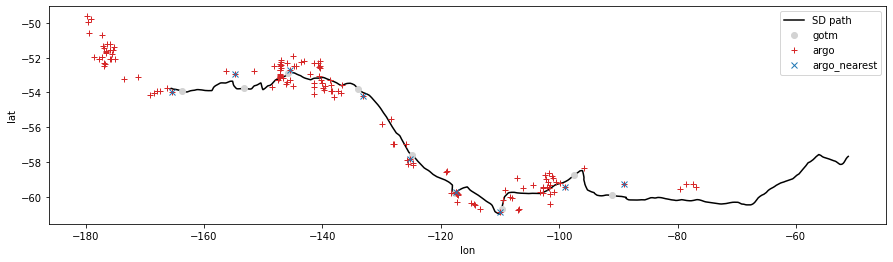

In [12]:
fig = plt.figure(figsize=[15, 4])
sdlon = sd_ds.lon
sdlat = sd_ds.lat
plt.plot(sdlon, sdlat, 'k', label='SD path')
plt.plot(sdlon[idx_sd], sdlat[idx_sd], 'o', color='lightgray', label='gotm')
argolon = argo_ds.lon
argolat = argo_ds.lat
plt.plot(argolon, argolat, '+', color='tab:red', label='argo')
plt.plot(argolon[nearest_ind], argolat[nearest_ind], 'x', color='tab:blue', label='argo_nearest')
plt.legend()
plt.xlabel('lon')
plt.ylabel('lat')

(-500.0, 0.0)

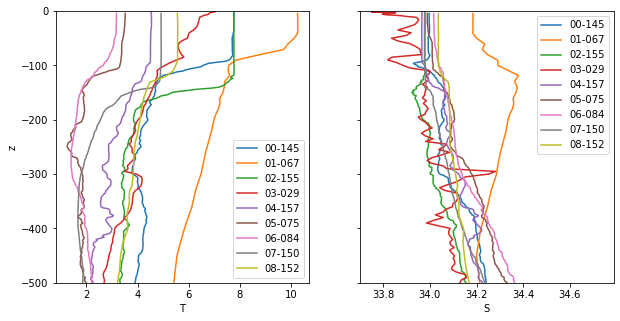

In [13]:
fig, axarr = plt.subplots(1,2, sharey='row')
fig.set_size_inches([10,5])
for i,idx in enumerate(nearest_ind):
    tpfl = argo_ds.temp[idx,:]
    spfl = argo_ds.salt[idx,:]
    z = argo_ds.z[idx,:]
    axarr[0].plot(tpfl, z, label='{:02d}-{:03d}'.format(i, idx))
    axarr[1].plot(spfl, z, label='{:02d}-{:03d}'.format(i, idx))
axarr[0].legend()
axarr[1].legend()
axarr[0].set_xlabel('T')
axarr[1].set_xlabel('S')
axarr[0].set_ylabel('z')
axarr[0].set_ylim([-500, 0])

### Save data

In [14]:
year = 2019
zbot = -500
for i,idx in enumerate(idx_sd):
    cname = 'C{:04d}'.format(idx)
    argo_idx = nearest_ind[i]
    print(cname)
    dttime_argo = pd.to_datetime(year*1000 + sd_ds.time.data[idx], format='%Y%j')
    zz = argo_ds.z[argo_idx,:].data
    zidx = np.nanargmin(np.abs(zz-zbot))
    zz_argo = zz[:zidx]
    os.makedirs(os.path.join(dataroot, cname), exist_ok=True)
    dat_dump_pfl([dttime_argo],
                 zz_argo,
                 [argo_ds.temp[argo_idx:argo_idx+1,:zidx].data],
                 os.path.join(dataroot, cname, 't_prof.dat'),
                 skip_value=np.nan)
    dat_dump_pfl([dttime_argo],
                 zz_argo,
                 [argo_ds.salt[argo_idx:argo_idx+1,:zidx].data],
                 os.path.join(dataroot, cname, 's_prof.dat'),
                 skip_value=np.nan)
    hf = (sd_ds.qlat+sd_ds.qsens+sd_ds.lw).data[idx]
    tau = sd_ds.tau.data[idx]
    with open(os.path.join(dataroot, cname, 'config.dat'), 'w') as f:
        f.write('{}\n {:6.2f} {:6.2f} {:8.4f} {:8.4f} {:8.4f} {:8.4f}'.format(
            dttime_argo.strftime('%Y-%m-%d %H:%M:%S'),
            sd_ds.lon.data[idx], sd_ds.lat.data[idx],
            hf, tau, sd_ds.qlat.data[idx], sd_ds.qsens.data[idx]))

C0030
C0133
C0236
C0339
C0442
C0545
C0648
C0751
C0854


### Save case list

In [15]:
with open(os.path.join(dataroot, 'caselist.txt'), 'w') as f:
    for idx in idx_sd:
        cname = 'C{:04d}\n'.format(idx)
        f.write(cname)